In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
data = pd.read_csv('depression_cyp_dataset.csv')

In [3]:
#drop missing values
data = data.dropna()

In [4]:
#remove participants in S group
data = data[data['Assignment'] != 'S']

In [5]:
#remove outlier medications, change # medications column
data = data.drop(columns=['AD', 'M', 'C', 'A', 'X', 'N', 'W', 'U', 'G', 'S', 'I', 'E', 'O', 'Q'])

subset = ['B', 'D', 'F', 'H', 'J', 'K', 'L', 'P', 'R', 'T', 'V', 'Y', 'Z', 'AA', 'AB', 'AC']

data['# Psychotropic Medications'] = (data[subset] > 0).sum(axis=1)

In [6]:
#remove people given less than 2 meds
data = data[data['# Psychotropic Medications'] >= 2]

In [7]:
#Pick top 3 medication and use as target
subset_columns = ['B', 'D', 'F', 'H', 'J', 'K', 'L', 'P', 'R', 'T', 'V', 'Y', 'Z', 'AA', 'AB', 'AC']

# Assign the top 2 values to new columns
def get_top_2_columns(row):
    return pd.Series(row.nlargest(2).index)

# Apply the function to each row
data[['Med1', 'Med2']] = data[subset_columns].apply(get_top_2_columns, axis=1)

In [8]:
# Extract features and target variable (medication)
features = ['AGE','GENDER','RACE/ETHNICITY', 'Therapeutic Guidances', 'Diagnosis']
target = ['Med1', 'Med2']


X = data[features].copy()
y = data[target].copy()

In [9]:
#Split diagnosis into true/false categories
#Categories: MDD, Severe, Recurrent, Psychotic
keywords = ['MDD', 'Major depressive disorder', 'Major depression']
pattern = '|'.join(keywords)
X['MDD'] = X['Diagnosis'].str.contains(pattern, case=False, na=False)
X['Severe'] = X['Diagnosis'].str.contains('Severe', case=False, na=False)
X['Recurrent'] = X['Diagnosis'].str.contains('Recurrent', case=False, na=False)
X['Psychotic'] = X['Diagnosis'].str.contains('With Psychotic|with psychosis', case=False, na=False)
X = X.drop('Diagnosis', axis=1)

In [10]:
#normalize age
X['AGE']=(X['AGE']-X['AGE'].min())/(X['AGE'].max()-X['AGE'].min())

In [11]:
#one hot encode race
oh = pd.get_dummies(X['RACE/ETHNICITY'])
X = X.join(oh)
X = X.drop('RACE/ETHNICITY',axis = 1)

In [12]:
#encode gender to 0/1
X['GENDER'] = X['GENDER'].replace('M',1)
X['GENDER'] = X['GENDER'].replace('F', 0)

#one hot encoding for therapeutic guidances
one_hot = pd.get_dummies(X['Therapeutic Guidances'])
X = X.join(one_hot)
X = X.drop('Therapeutic Guidances',axis = 1)
X.head()

,AGE,GENDER,MDD,Severe,Recurrent,Psychotic,B,L,O/U,W,CT,EG,TL
0,0.462687,0,True,False,True,False,False,False,False,True,False,True,False
1,0.044776,0,True,False,True,False,False,False,False,True,True,False,False
2,0.149254,1,True,True,False,True,False,True,False,False,True,False,False
3,0.671642,0,False,False,False,False,False,True,False,False,True,False,False
6,0.358209,1,True,False,False,False,False,False,False,True,False,True,False


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
model = MultiOutputClassifier(svm_classifier)

In [15]:
# Train the model
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=SVC(kernel='linear', random_state=42))

In [16]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [17]:
# Evaluate model performance using metrics like accuracy, precision, recall, F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_list = []
precision_list = []
recall_list = []

# Loop through each target variable
for i in range(y_test.shape[1]):
    # Calculate accuracy for the ith target variable
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    accuracy_list.append(accuracy)

    # Calculate precision for the ith target variable
    precision = precision_score(y_test.iloc[:, i], y_pred[:, i], average='weighted')
    precision_list.append(precision)

    # Calculate recall for the ith target variable
    recall = recall_score(y_test.iloc[:, i], y_pred[:, i], average='weighted')
    recall_list.append(recall)

    #Calculate F1 score for the ith target variable

    # Print or store the metrics
    print(f'Medication {i+1}: Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}')

# Calculate overall metrics (optional)
overall_accuracy = sum(accuracy_list) / len(accuracy_list)
overall_precision = sum(precision_list) / len(precision_list)
overall_recall = sum(recall_list) / len(recall_list)

print(f'Overall Metrics: Accuracy={overall_accuracy:.2f}, Precision={overall_precision:.2f}, Recall={overall_recall:.2f}')

Medication 1: Accuracy=0.19, Precision=0.12, Recall=0.19
Medication 2: Accuracy=0.32, Precision=0.10, Recall=0.32
Overall Metrics: Accuracy=0.25, Precision=0.11, Recall=0.25


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#process new input
#David: Latino, M, 56, MDD recurrent
def normalize_age(age):
    return (age - 18) / (85 - 18)

def get_patient_profile(age, gender, race, diagnosis, tg):
    #process age and gender
    age = normalize_age(age)
    gender = 1 if gender == 'M' else 0

    #process race
    possible_inputs = ['B', 'L', 'O/U', 'W']
    race_p = [race == val for val in possible_inputs]

    #process diagnosis
    possible_inputs = ['MDD', 'Severe', 'Recurrent', 'Psychotic']
    diag_p = [val in diagnosis for val in possible_inputs]

    #process TG
    possible_inputs = ['Abnormal', 'Normal', 'Extreme']
    tg_p = [tg == val for val in possible_inputs]

    #combine all
    patient_profile = [age, gender] + diag_p + race_p + tg_p

    #make it valid input for model
    patient_profile = np.array([patient_profile])
    patient_profile = patient_profile.reshape(1, -1)
    return patient_profile

In [19]:
david = get_patient_profile(56, 'M', 'L', ['MDD', 'Recurrent'], 'Abnormal')

In [20]:
#testing with new input
print(model.predict(david))

[['F' 'AB']]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


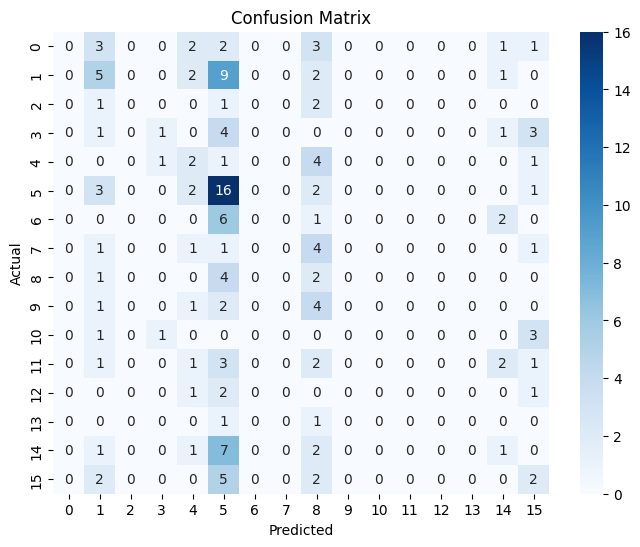

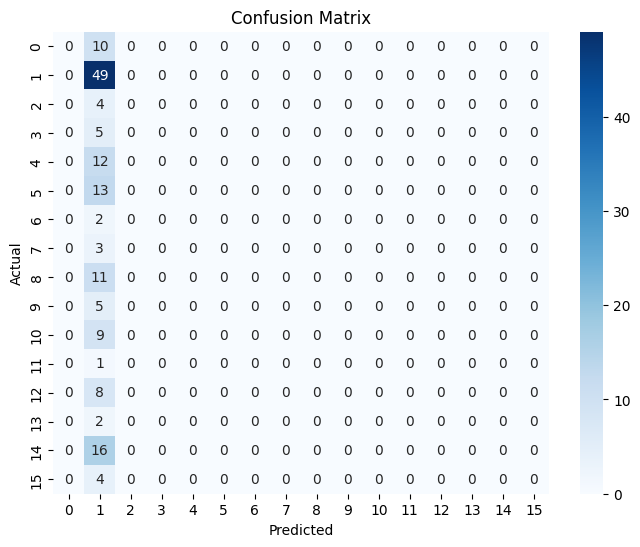

In [21]:
#Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrices = []
for i in range(y.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    confusion_matrices.append(cm)
    #print(f'Confusion Matrix for output {i}:\n{cm}\n')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()